In [51]:
import torch
import torch.nn.functional as F
from typing import List, Tuple, Optional, Any
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [52]:
from multiprocessing import cpu_count
# torch.set_num_threads(cpu_count() - 1)
torch.set_num_threads(4)

In [53]:
# build vocabulary
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

vocab = sorted(list(set(''.join(words))))

stoi = {s:i for i,s in enumerate(vocab, start=1)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [54]:
# build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X,Y

In [55]:
# train, val, test split
random.shuffle(words)

train_split = .8; val_split = .1

n1 = int(train_split * len(words))
n2 = int((train_split + val_split) * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [56]:
g = torch.Generator().manual_seed(2147483647)

In [57]:
class Linear: # torch.nn.Linear
    def __init__(self, fan_in: torch.Tensor, fan_out: torch.Tensor, bias: bool = True) -> None:
        self.weight: torch.Tensor = torch.randn((fan_in, fan_out), generator=g)
        self.weight = self.weight / (fan_in ** 0.5) # gain initialization
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # print(x.shape, self.weight.shape)
        self.out = x @ self.weight
        if self.bias is not None:
            # print(self.out.shape)
            self.out += self.bias

        return self.out
    
    def parameters(self) -> List:
        return [self.weight] + ([] if self.bias is None else [self.bias])


In [58]:
class BatchNorm1d:
    def __init__(
        self,
        num_features: int,
        eps: float = 1e-5,
        momentum: float = 0.1,
        affine=True,
        track_running_stats=True,
    ) -> None:
        # initialization
        self.eps = eps
        self.momentum = momentum
        self.training = True  # different behaviours during training and evaluation such as optim of gamma & beta during training but not during eval

        # params (trained w. backprop update)
        self.gamma = torch.ones((num_features))
        self.beta = torch.zeros((num_features))

        # buffers (trained w. running momentum update)
        self.running_mean = torch.zeros(num_features)
        self.running_variance = torch.ones(num_features)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # forward pass
        if self.training:
            mean = x.mean(0, keepdim=True) # batch mean
            variance = x.var(0, keepdim=True) # batch variance
        else:
            mean = self.running_mean
            variance = self.running_variance
        
        xhat = (x - mean) / torch.sqrt(variance + self.eps)
        self.out = xhat * self.gamma + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                self.running_variance = (1 - self.momentum) * self.running_variance + self.momentum * variance
        
        return self.out
    
    def parameters(self) -> List:
        return [self.gamma, self.beta]

        



In [59]:
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = F.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [60]:
n_embed = 10
n_hidden = 100
block_size = 3

In [61]:
C = torch.randn((vocab_size, n_embed), generator=g).float()
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(), # input_layer
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), # output layer
]

In [62]:
# layer init
with torch.no_grad():
    # last layer: make less confident
    if isinstance(layers[-1], BatchNorm1d):
        # layers[-1].weight *= 0.1 ## without batchnorm
        layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

pitolayer = {}
counter = 1
for layer in layers:
    for _ in layer.parameters():
        pitolayer[counter] = layer.__class__.__name__
        counter += 1

print(f"Total Num of Parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

print(len(pitolayer), len(parameters))

Total Num of Parameters: 47551
24 25


In [63]:
len(parameters)

25

In [64]:
n_epochs = 200_000
batch_size = 32

lossi = []
ud = []  # update:data ratio at each step

for i in range(n_epochs):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    emb = C[X_train[ix]]

    # forward pass
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x: torch.Tensor = layer(x)
    loss: torch.Tensor = F.cross_entropy(x, Y_train[ix])

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  ## DEBUG: won't be present in regular training
    for p in parameters:
        p.grad = None  # zero grad

    loss.backward()

    # update
    lr = 10**-1 if i < 100_000 else (10**-2 if i < 150_000 else 10**-3)
    for pi, p in enumerate(parameters):
        # try:
        p.data += -lr * p.grad
    # except Exception as e:
    #     print(i, pi, p.grad)
    #     raise e

    # track stats
    lossi.append((i, loss.log10().item()))
    with torch.no_grad():
        ud.append(
            [((lr * p.grad).std() / p.data.std()).log10().item() for p in parameters]
        )  # taking log10 to just see the exponents for better viz

    if i % 10_000 == 0:
        print(f"Step {i} / {n_epochs}: Loss: {loss:.4f}")

    # if i > 1000:  ## DEBUG: Need to track something so just running until n-th epoch
    #     break  ## DEBUG: Need to track something so just running 1 epoch

Step 0 / 200000: Loss: 3.2973


Step 10000 / 200000: Loss: 2.0930
Step 20000 / 200000: Loss: 2.5101
Step 30000 / 200000: Loss: 2.1712
Step 40000 / 200000: Loss: 1.8808
Step 50000 / 200000: Loss: 1.8984
Step 60000 / 200000: Loss: 2.1134
Step 70000 / 200000: Loss: 2.1185
Step 80000 / 200000: Loss: 2.2916
Step 90000 / 200000: Loss: 2.0247
Step 100000 / 200000: Loss: 2.1152
Step 110000 / 200000: Loss: 1.5720
Step 120000 / 200000: Loss: 2.1742
Step 130000 / 200000: Loss: 2.2715
Step 140000 / 200000: Loss: 2.3071
Step 150000 / 200000: Loss: 1.9194
Step 160000 / 200000: Loss: 2.2732
Step 170000 / 200000: Loss: 2.1712
Step 180000 / 200000: Loss: 2.1432
Step 190000 / 200000: Loss: 2.1002


In [65]:
for layer in layers:
    layer.training = False

layer 2 (Tanh      ): mean -0.02 std: 0.69 saturation: 14.44%
layer 5 (Tanh      ): mean -0.01 std: 0.73 saturation: 17.16%
layer 8 (Tanh      ): mean -0.03 std: 0.75 saturation: 15.97%
layer 11 (Tanh      ): mean -0.01 std: 0.77 saturation: 17.16%
layer 14 (Tanh      ): mean -0.01 std: 0.78 saturation: 17.41%


Text(0.5, 1.0, 'activation distribution')

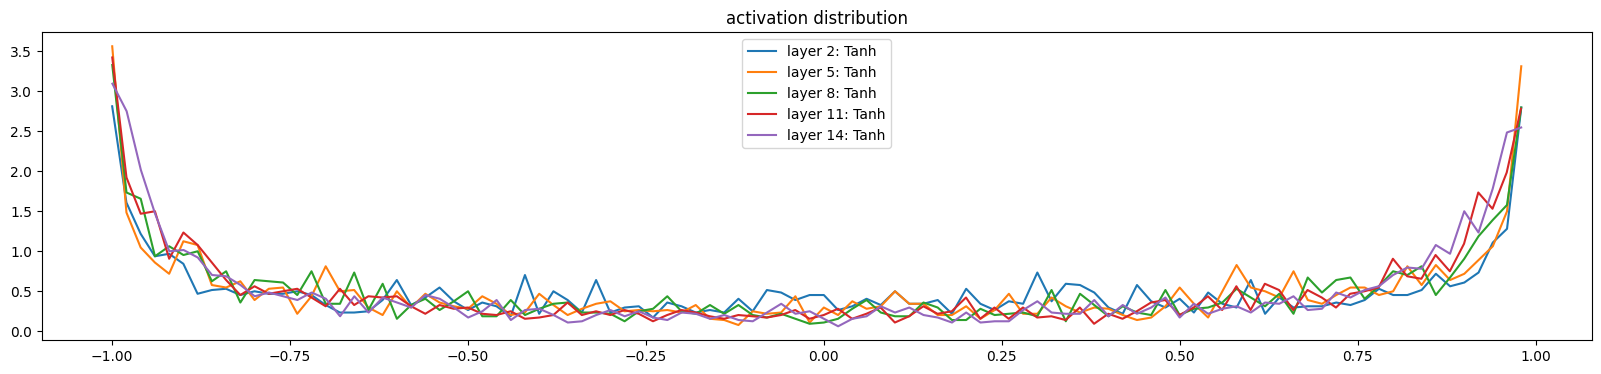

In [66]:
# visualize histograms - activation distribution
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the softmax (output) layer
    if isinstance(layer, Tanh):
        t: torch.Tensor = layer.out
        print(f"layer {i} ({layer.__class__.__name__:<10}): mean {t.mean():+.2f} std: {t.std():.2f} saturation: {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}: {layer.__class__.__name__}")
plt.legend(legends)
plt.title('activation distribution')

layer 2 (Tanh      ): mean -0.000000 std: 3.743393e-03
layer 5 (Tanh      ): mean +0.000000 std: 3.232811e-03
layer 8 (Tanh      ): mean -0.000000 std: 3.119146e-03
layer 11 (Tanh      ): mean -0.000000 std: 3.112124e-03
layer 14 (Tanh      ): mean +0.000000 std: 3.534333e-03


Text(0.5, 1.0, 'gradient distribution')

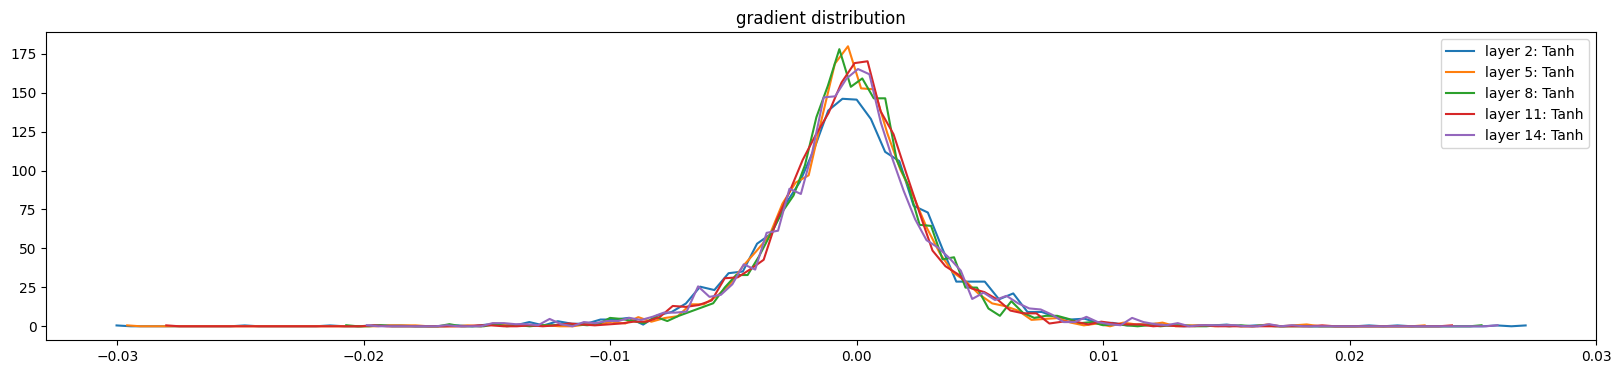

In [67]:
# visualize histograms - gradient distribution
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the softmax (output) layer
    if isinstance(layer, Tanh):
        t: torch.Tensor = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__:<10}): mean {t.mean():+f} std: {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}: {layer.__class__.__name__}")
plt.legend(legends)
plt.title('gradient distribution')

weight        (27, 10) | mean -0.000000 | std1.304422e-02 | grad:data ratio 1.195055e-02
weight       (30, 100) | mean +0.000125 | std7.357947e-03 | grad:data ratio 1.793376e-02
weight      (100, 100) | mean -0.000048 | std4.998580e-03 | grad:data ratio 2.014460e-02
weight      (100, 100) | mean -0.000162 | std4.693499e-03 | grad:data ratio 1.927524e-02
weight      (100, 100) | mean -0.000072 | std4.551620e-03 | grad:data ratio 1.921293e-02
weight      (100, 100) | mean +0.000035 | std4.537728e-03 | grad:data ratio 1.990637e-02
weight       (100, 27) | mean -0.000057 | std8.466111e-03 | grad:data ratio 2.593567e-02


Text(0.5, 1.0, 'weights gradient distribution')

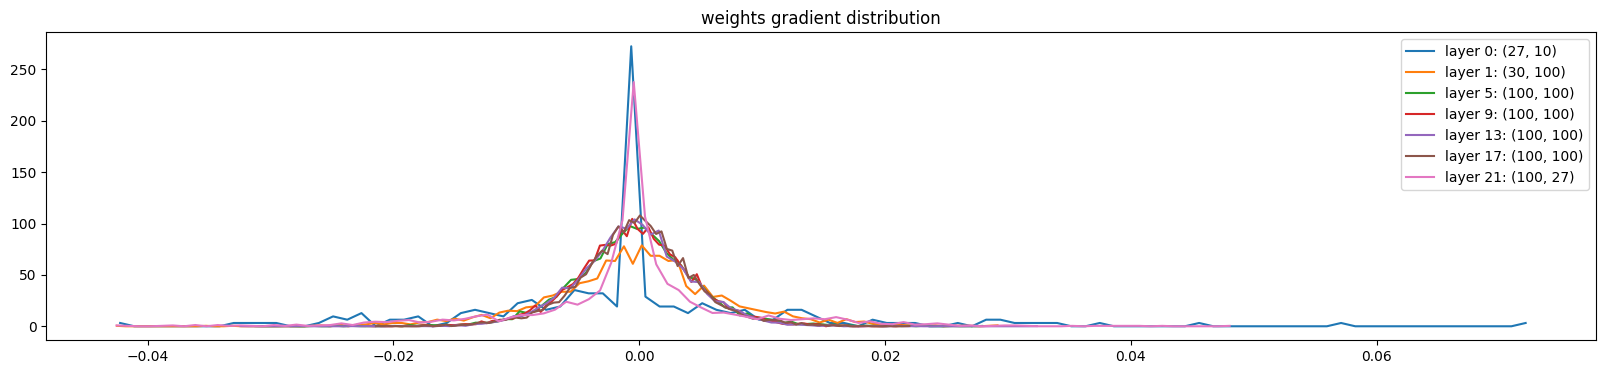

In [68]:
# visualize histograms - weights gradient distribution
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):  # exclude the softmax (output) layer
    t: torch.Tensor = p.grad
    if p.ndim == 2:
        print(
            f"weight {str(tuple(p.shape)):>15} | mean {t.mean():+f} | std{t.std():e} | grad:data ratio {t.std() / p.std():e}"
        )
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}: {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution")

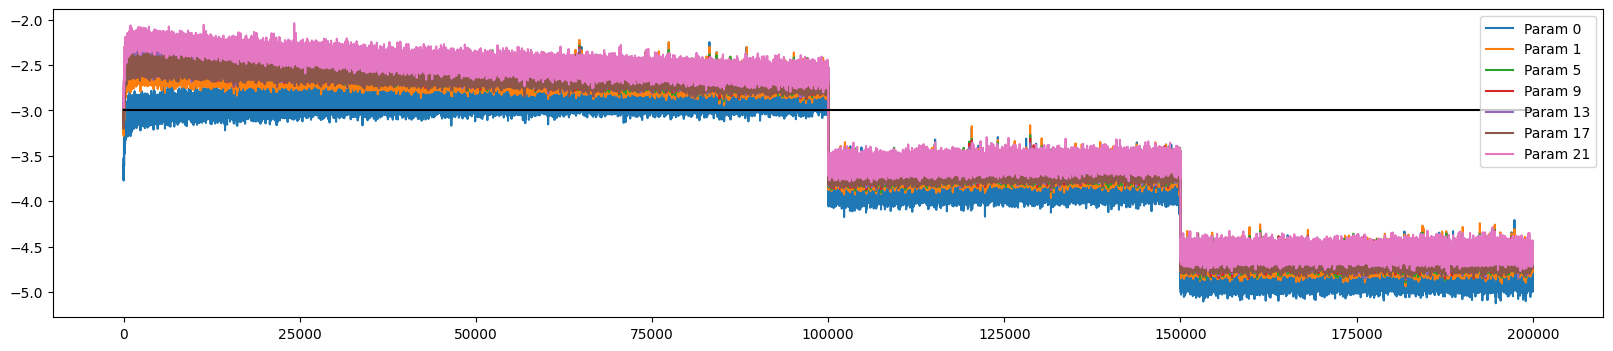

In [69]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"Param {i}")
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [70]:
@torch.no_grad()  # decorator prevents gradient tracking
def split_loss(split: str):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]
    print(emb.shape)
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x: torch.Tensor = layer(x)
    loss: torch.Tensor = F.cross_entropy(x, y)

    print(f"{split} loss = {loss.item()}")


split_loss("train")
split_loss("val")
split_loss("test")

torch.Size([182679, 3, 10])


train loss = 2.0132484436035156
torch.Size([22688, 3, 10])
val loss = 2.1068155765533447
torch.Size([22779, 3, 10])
test loss = 2.1007888317108154


In [71]:
# sample from the model

def sample(num_samples: int = 20):
    for _ in range(num_samples):
        samples = []
        context = [0] * block_size # init with all ...
        while True:
            # forward pass the neural net
            emb = C[torch.tensor([context])]
            x = emb.view(emb.shape[0], block_size * n_embed)
            for layer in layers:
                # print(x)
                x: torch.Tensor = layer(x)
            probs = F.softmax(x)
            # print(x)
            # sample from the distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [ix]
            samples.append(ix)
            if ix == 0:
                break
        
        print(''.join(itos[i] for i in samples))

sample()

pip.
sebancee.
clus.
jenlynn.
amelle.
billie.
fnanda.
kie.
viyah.
nourne.
josiah.
bro.
eishishmiyanne.
devon.
azalexizoulmera.
azara.
nat.
maria.
caysencixedge.
cianna.


/tmp/ipykernel_8949/593898216.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(x)
